In [2]:
import wandb 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [44]:
from cycler import cycler

# --- 1. Setup UofT Style (Embedded for portability) ---
def apply_uoft_style():
    # Hex codes converted from UofT Brand Guidelines
    uoft_colors = {
        'blue':          '#1E3765',  # Primary
        'secondary_blue':'#007FA3',  # Secondary
        'purple':        '#6D247A',
        'warm_red':      '#DC4633',
        'cool_blue':     '#6FC7EA',
        'teal':          '#00A189',
        'fuchsia':       '#AB1368',
        'dark_green':    '#0D534D',
        'yellow':        '#F1C500',
        'light_green':   '#8DBF2E',
        'cool_gray':     '#D0D1C9',
    }

    uoft_style = {
        # Color Cycle: Primary -> Warm Red -> Secondary Blue -> Teal -> Fuchsia -> Yellow
        'axes.prop_cycle': cycler(color=[
            uoft_colors['blue'],
            uoft_colors['warm_red'],
            uoft_colors['secondary_blue'],
            uoft_colors['teal'],
            uoft_colors['fuchsia'],
            uoft_colors['yellow'],
        ]),
        
        # Figure Layout
        'figure.facecolor': 'white',
        'figure.figsize': (12, 8),
        'figure.dpi': 120,
        
        # Axes & Grid
        'axes.facecolor': 'white',
        'axes.edgecolor': uoft_colors['blue'],
        'axes.linewidth': 1.2,
        'axes.labelcolor': uoft_colors['blue'],
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'axes.grid': True,
        'axes.axisbelow': True,
        
        'grid.color': uoft_colors['cool_gray'],
        'grid.linestyle': '--',
        'grid.linewidth': 0.8,
        'grid.alpha': 0.6,
        
        # Fonts & Text
        'text.color': uoft_colors['blue'],
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        
        # Legend
        'legend.frameon': True,
        'legend.framealpha': 0.95,
        'legend.facecolor': 'white',
        'legend.edgecolor': uoft_colors['cool_gray'],
        'legend.fontsize': 10,
    }
    plt.rcParams.update(uoft_style)
    return uoft_colors

colors = apply_uoft_style()

In [132]:
api = wandb.Api()

In [133]:
project = "jasper-gerigk/recursive-LLM"

In [134]:
datasets = ['allenai/ai2_arc', 'cais/mmlu', 'TIGER-Lab/MMLU-Pro']
def get_runs_by_filter(filter, ignore_model_version=False):
    runs = api.runs(project, filter)
    ordered_runs = []
    for dataset in datasets:
        for run in runs:
            if dataset == run.config['script_args']['dataset_name'] and (ignore_model_version or run.config['script_args']['model_name'] == 'Qwen/Qwen3-0.6B'):
                ordered_runs.append(run)
    # assert len(ordered_runs) == len(datasets)
    return ordered_runs

def get_runs_by_regex(regex):
    return get_runs_by_filter({"display_name": {"$regex": regex}})

baseline = get_runs_by_filter({"config.loop_args.enable_loop": False, "config.hs_args.enable_hidden_state_injection": False})
fixed_hsinj = get_runs_by_regex("hsinj\(f\) x1")
fixed_hsinj_2 = get_runs_by_regex("hsinj\(f\) x2")
hsinj= get_runs_by_regex("hsinj x1$")
hsinj_2 = get_runs_by_regex("hsinj x2$")
better_prompt_1 = get_runs_by_filter({'config.hs_args.baseline_no_injection': True, 'config.hs_args.num_iterations': 1})
better_prompt_2 = get_runs_by_filter({'config.hs_args.baseline_no_injection': True, 'config.hs_args.num_iterations': 2})

In [135]:
hsinj_2

[<Run jasper-gerigk/recursive-LLM/rio193u4 (finished)>,
 <Run jasper-gerigk/recursive-LLM/8n6pv3n4 (finished)>]

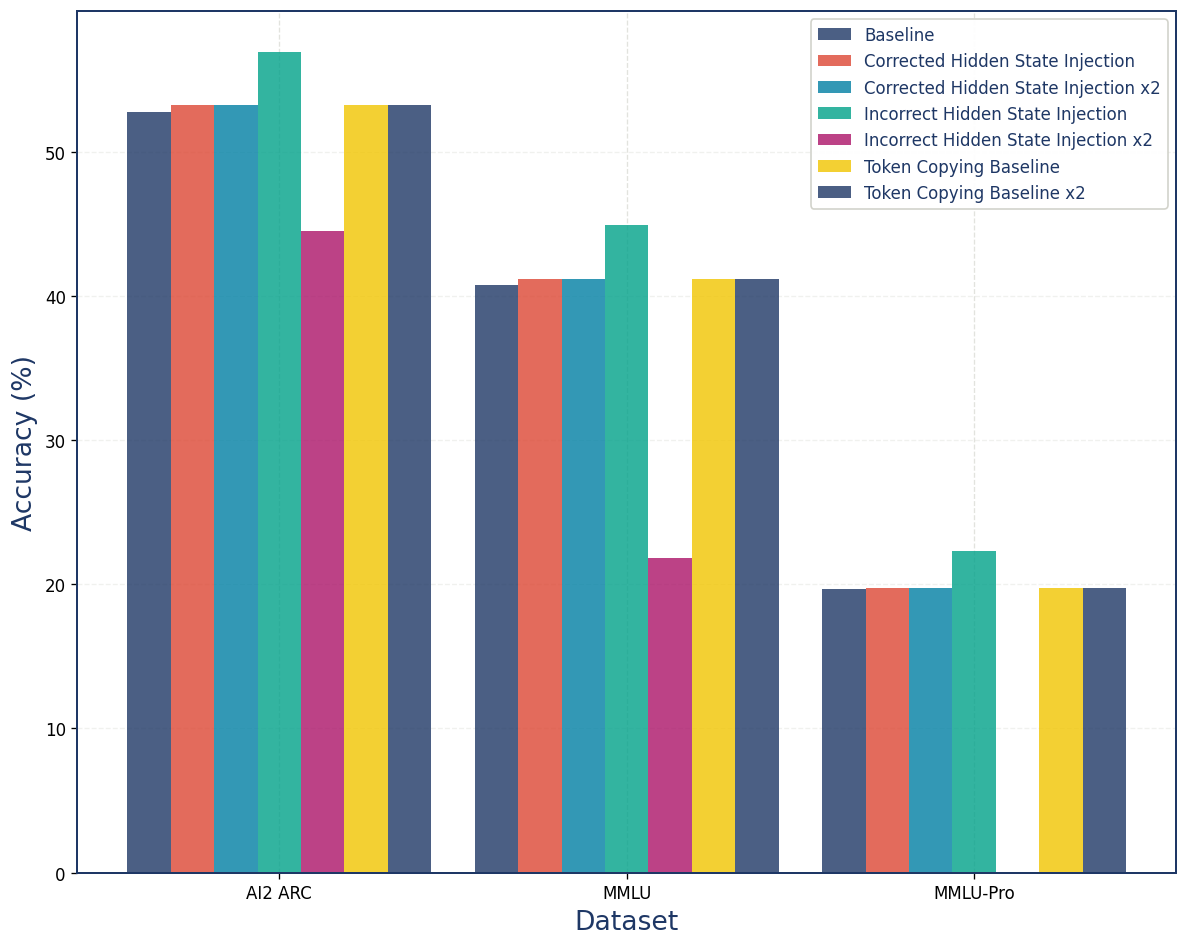

In [138]:
def extract_metrics(runs: list, metric_name: str) -> list:
    """Extract a specific metric from a list of runs."""
    return [run.summary.get(metric_name, 0) for run in runs]

baseline_accuracy = extract_metrics(baseline, 'accuracy')
fixed_hsinj_accuracy = extract_metrics(fixed_hsinj, 'accuracy')
fixed_hsinj_2_accuracy = extract_metrics(fixed_hsinj_2, 'accuracy')
hsinj_accuracy = extract_metrics(hsinj, 'accuracy')
hsinj_2_accuracy = extract_metrics(hsinj_2, 'accuracy')
better_prompt_1_accuracy = extract_metrics(better_prompt_1, 'accuracy')
better_prompt_2_accuracy = extract_metrics(better_prompt_2, 'accuracy')

baseline_invalid = extract_metrics(baseline, 'invalid_answer_percentage')
fixed_hsinj_invalid = extract_metrics(fixed_hsinj, 'invalid_answer_percentage')
fixed_hsinj_2_invalid = extract_metrics(fixed_hsinj_2, 'invalid_answer_percentage')
hsinj_invalid = extract_metrics(hsinj, 'invalid_answer_percentage')
hsinj_2_invalid = extract_metrics(hsinj_2, 'invalid_answer_percentage')
better_prompt_1_invalid = extract_metrics(better_prompt_1, 'invalid_answer_percentage')
better_prompt_2_invalid = extract_metrics(better_prompt_2, 'invalid_answer_percentage')

dataset_labels = ['AI2 ARC', 'MMLU', 'MMLU-Pro']
x = np.arange(len(dataset_labels))*2
width = 0.25

fig, ax = plt.subplots(figsize=(10, 8))
bars1 = ax.bar(x - width*3, baseline_accuracy, width, label='Baseline', alpha=0.8)
bars2 = ax.bar(x - width*2, fixed_hsinj_accuracy, width, label='Corrected Hidden State Injection', alpha=0.8)
bars3 = ax.bar(x - width, fixed_hsinj_2_accuracy, width, label='Corrected Hidden State Injection x2', alpha=0.8)
bars4 = ax.bar(x, hsinj_accuracy, width, label='Incorrect Hidden State Injection', alpha=0.8)
bars5 = ax.bar((x + width)[:len(hsinj_2_accuracy)], hsinj_2_accuracy, width, label='Incorrect Hidden State Injection x2', alpha=0.8)
bars6 = ax.bar(x + width*2, better_prompt_1_accuracy, width, label='Token Copying Baseline', alpha=0.8)
bars7 = ax.bar((x + width*3)[:len(better_prompt_2_accuracy)], better_prompt_2_accuracy, width, label='Token Copying Baseline x2', alpha=0.8)

ax.set_xlabel('Dataset', fontsize=16)
ax.set_ylabel('Accuracy (%)', fontsize=16)
# ax.set_title('Accuracy Comparison Across Datasets', fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(dataset_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# for bars in [bars1, bars2, bars3, bars4, bars5, bars6, bars7]:
#     for bar in bars:
#         height = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{height:.2f}%',
#                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
# plt.show()
plt.savefig('hs_accuracy.png')

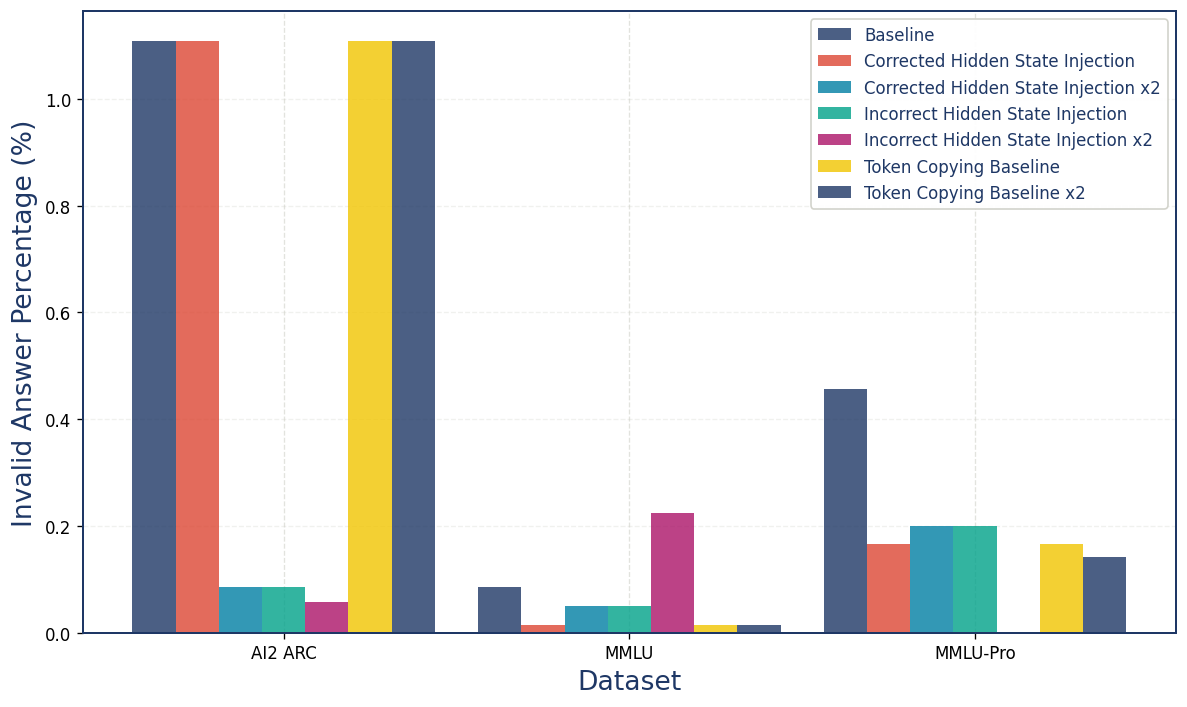

In [137]:
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width*3, baseline_invalid, width, label='Baseline', alpha=0.8)
bars2 = ax.bar(x - width*2, fixed_hsinj_invalid, width, label='Corrected Hidden State Injection', alpha=0.8)
bars3 = ax.bar(x - width, hsinj_invalid, width, label='Corrected Hidden State Injection x2', alpha=0.8)
bars4 = ax.bar(x[:len(hsinj_invalid)], hsinj_invalid, width, label='Incorrect Hidden State Injection', alpha=0.8)
bars5 = ax.bar((x + width)[:len(hsinj_2_accuracy)], hsinj_2_invalid, width, label='Incorrect Hidden State Injection x2', alpha=0.8)
bars6 = ax.bar(x + width*2, better_prompt_1_invalid, width, label='Token Copying Baseline', alpha=0.8)
bars7 = ax.bar((x + width*3)[:len(better_prompt_2_invalid)], better_prompt_2_invalid, width, label='Token Copying Baseline x2', alpha=0.8)

ax.set_xlabel('Dataset', fontsize=16)
ax.set_ylabel('Invalid Answer Percentage (%)', fontsize=16)
# ax.set_title('Invalid Answer Percentage Comparison Across Datasets', fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(dataset_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# for bars in [bars1, bars2, bars3]:
#     for bar in bars:
#         height = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{height:.2f}%',
#                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
# plt.show()
plt.savefig('hs_invalid.png')

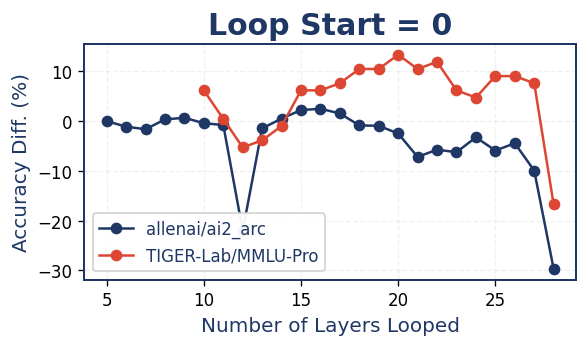

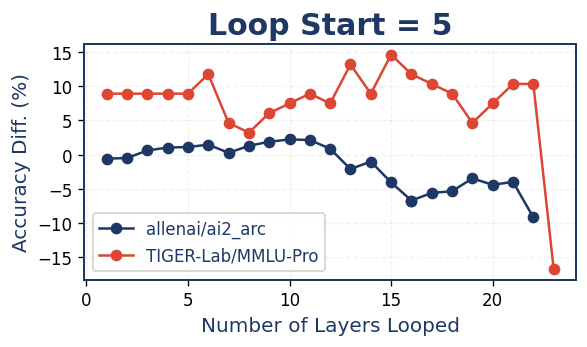

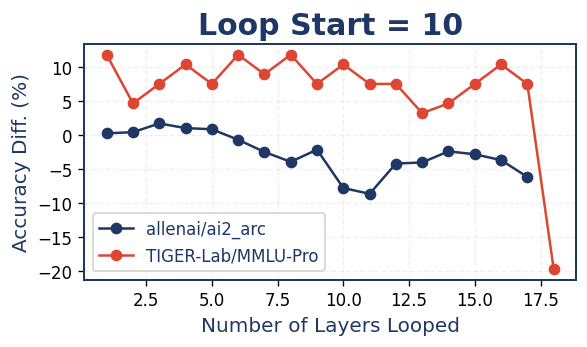

In [119]:
looping_dataset = ['allenai/ai2_arc', 'TIGER-Lab/MMLU-Pro']
loop_starts = [0, 5, 10]

for loop_start in loop_starts:
    plt.figure(figsize=(5, 3))
    for dataset in looping_dataset:
        runs = get_runs_by_filter({"config.loop_args.enable_loop": True, "config.loop_args.t_layer": loop_start, "config.loop_args.num_loops": 1, "config.script_args.dataset_name": dataset})
        runs = [run for run in runs if run.config["loop_args"]["k_layers"]]
        baseline_value = [b.summary["accuracy"] for b in baseline if b.config["script_args"]["dataset_name"] == dataset][0]
        x = [run.config["loop_args"]["k_layers"] for run in runs]
        values = [run.summary["accuracy"] - baseline_value for run in runs]
        x, values = zip(*sorted(zip(x, values), key=lambda x: x[0]))
        plt.plot(x, values, label=dataset, marker='o')
    plt.legend()
    plt.xlabel('Number of Layers Looped', fontsize=12)
    plt.ylabel('Accuracy Diff. (%)', fontsize=12)
    plt.title(f'Loop Start = {loop_start}', fontsize=18, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'looping_accuracy_loopstart_{loop_start}.png')



Qwen/Qwen3-0.6B
Qwen/Qwen3-1.7B
Qwen/Qwen3-4B
Qwen/Qwen3-8B


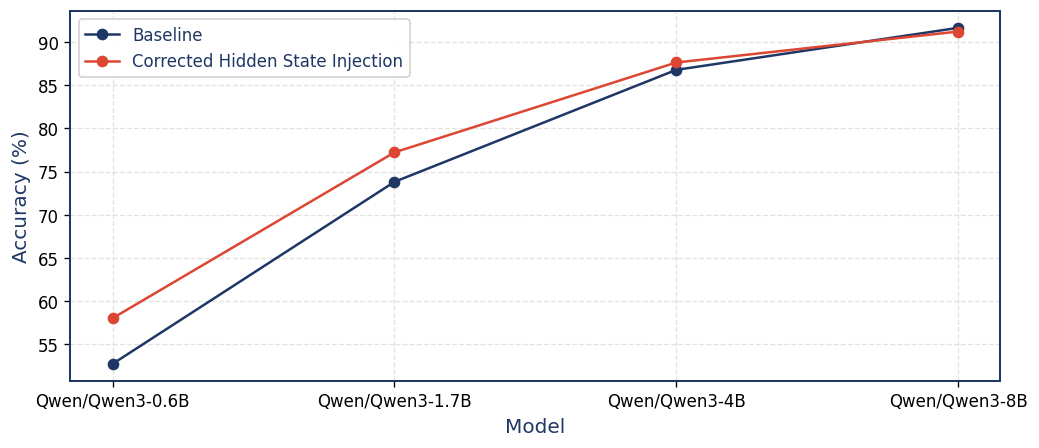

In [131]:
qwen_models = ['Qwen/Qwen3-0.6B', 'Qwen/Qwen3-1.7B', 'Qwen/Qwen3-4B', 'Qwen/Qwen3-8B']

baseline_accuracy = []
hsinj_accuracy = []
for model in qwen_models:
    print(model)
    baseline_run = get_runs_by_filter({"config.script_args.model_name": model, "config.hs_args.enable_hidden_state_injection": False, 
                                       "config.script_args.dataset_name": "allenai/ai2_arc"}, True)[0]
    baseline_accuracy.append(baseline_run.summary["accuracy"])
    hsinj_run = get_runs_by_filter({"config.script_args.model_name": model, "config.hs_args.enable_hidden_state_injection": True, 
                                    "config.script_args.dataset_name": "allenai/ai2_arc"}, True)[0]
    hsinj_accuracy.append(hsinj_run.summary["accuracy"])
    
plt.figure(figsize=(10, 4))
plt.plot(qwen_models, baseline_accuracy, label='Baseline', marker='o')
plt.plot(qwen_models, hsinj_accuracy, label='Corrected Hidden State Injection', marker='o')
plt.legend()
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.savefig('larger_models_accuracy.png')